# Datawhale 气象海洋预测-Task1 气象数据分析常用工具
气象科学中的数据通常包含多个维度，例如本赛题中给出的数据就包含年、月、经度、纬度四个维度，为了便于数据的读取和操作，气象数据通常采用netCDF文件来存储，文件后缀为.nc。

对于以netCDF文件存储的气象数据，有两个常用的数据分析库，即NetCDF4和Xarray。在此次任务中，我们将学习这两个库的基本对象和基本操作，掌握用这两个库读取和处理气象数据的基本方法。

## 学习目标
1.了解和学习NetCDF4和Xarray的基本对象和基本操作，掌握用这两个库读取和处理气象数据的基本方法。

## 内容介绍
1. NetCDF4
    - 创建、打开和关闭netCDF文件
    - 组（Groups）
    - 维度（Dimensions）
    - 变量（Variables）
    - 属性（Attributes）
    - 写入或读取变量数据
    - 应用
2. Xarray
    - 创建DataArray
    - 索引
    - 属性
    - 计算
    - GroupBy
    - 绘图
    - 与Pandas对象相互转换
    - Dataset
    - 读/写netCDF文件
    - 应用

## NetCDF4
[官方文档](http://unidata.github.io/netcdf4-python/#introduction)

NetCDF4是NetCDF C库的Python模块，支持Groups、Dimensions、Variables和Attributes等对象类型及其相关操作。

安装NetCDF4

In [9]:
!pip install netCDF4

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 4.7 MB 224 kB/s eta 0:00:01
     |████████████████████████████████| 216 kB 211 kB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [1]:
import netCDF4 as nc

### 创建、打开和关闭netCDF文件

NetCDF4可以通过调用Dataset创建netCDF文件或打开已存在的文件，并通过查看data_model属性确定文件的格式。需要注意创建或打开文件后要先关闭文件才能再次调用Dataset打开文件。

- 创建netCDF文件

In [2]:
from netCDF4 import Dataset

# Dataset包含三个输入参数：文件名，模式（其中'w', 'r+', 'a'为可写入模式），文件格式
test = Dataset('test.nc', 'w', 'NETCDF4')

- 打开已存在的netCDF文件

In [3]:
# 打开训练样本中的SODA数据
soda = Dataset('SODA_train.nc')

- 查看文件格式

In [4]:
print(soda.data_model)

NETCDF4


- 关闭netCDF文件

In [5]:
soda.close()

### Groups

NetCDF4支持按层级的组（Groups）来组织数据，类似于文件系统中的目录，Groups中可以包含Variables、Dimenions、Attributes对象以及其他Groups对象，Dataset会创建一个特殊的Groups，称为根组（Root Group），类似于根目录，使用Dataset.createGroup方法创建的组都包含在根组中。

- 创建Groups

In [6]:
# 接受一个字符串参数作为Group名称
group1 = test.createGroup('group1')
group2 = test.createGroup('group2')

- 查看文件中的所有Groups

In [7]:
# 返回一个Group字典
test.groups

OrderedDict([('group1', <class 'netCDF4._netCDF4.Group'>
              group /group1:
                  dimensions(sizes): 
                  variables(dimensions): 
                  groups: ), ('group2', <class 'netCDF4._netCDF4.Group'>
              group /group2:
                  dimensions(sizes): 
                  variables(dimensions): 
                  groups: )])

- Groups嵌套

In [8]:
# 在group1和group2下分别再创建一个Group
group1_1 = test.createGroup('group1/group11')
group2_1 = test.createGroup('group2/group21')

In [9]:
test.groups

OrderedDict([('group1', <class 'netCDF4._netCDF4.Group'>
              group /group1:
                  dimensions(sizes): 
                  variables(dimensions): 
                  groups: group11), ('group2', <class 'netCDF4._netCDF4.Group'>
              group /group2:
                  dimensions(sizes): 
                  variables(dimensions): 
                  groups: group21)])

In [10]:
test.groups.values()

odict_values([<class 'netCDF4._netCDF4.Group'>
group /group1:
    dimensions(sizes): 
    variables(dimensions): 
    groups: group11, <class 'netCDF4._netCDF4.Group'>
group /group2:
    dimensions(sizes): 
    variables(dimensions): 
    groups: group21])

- 遍历查看所有Groups

In [11]:
# 定义一个生成器函数用来遍历所有目录树
def walktree(top):
    values = top.groups.values()
    yield values
    for value in top.groups.values():
        for children in walktree(value):
            yield children

In [12]:
for groups in walktree(test):
    for group in groups:
        print(group)

<class 'netCDF4._netCDF4.Group'>
group /group1:
    dimensions(sizes): 
    variables(dimensions): 
    groups: group11
<class 'netCDF4._netCDF4.Group'>
group /group2:
    dimensions(sizes): 
    variables(dimensions): 
    groups: group21
<class 'netCDF4._netCDF4.Group'>
group /group1/group11:
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
<class 'netCDF4._netCDF4.Group'>
group /group2/group21:
    dimensions(sizes): 
    variables(dimensions): 
    groups: 


### Dimensions

NetCDF4用维度来定义各个变量的大小，例如本赛题中训练样本的第二维度month就是一个维度对象，每个样本包含36个月的数据，因此month维度内的变量的大小就是36。变量是包含在维度中的，因此在创建每个变量时要先创建其所在的维度。

- 创建Dimensions

Dataset.createDimension方法接受两个参数：维度名称，维度大小。维度大小设置为None或0时表示无穷维度。

In [13]:
# 创建无穷维度
level = test.createDimension('level', None)
time = test.createDimension('time', None)
# 创建有限维度
lat = test.createDimension('lat', 180)
lon = test.createDimension('lon', 360)

- 查看Dimensions

In [14]:
test.dimensions

OrderedDict([('level',
              <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'level', size = 0),
             ('time',
              <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0),
             ('lat',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 180),
             ('lon',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 360)])

- 查看维度大小

In [15]:
# 查看维度大小
print(len(lon))

360


In [16]:
# Dimension对象存储在字典中
print(level)

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'level', size = 0


In [17]:
# 判断维度是否是无穷
print(time.isunlimited())
print(lat.isunlimited())

True
False


### Variables

NetCDF4的Variables对象类似于Numpy中的多维数组，不同的是，NetCDF4的Variables变量可以存储在无穷维度中。

- 创建Variables

Dataset.createVariable方法接受的参数为：变量名，变量的数据类型，变量所在的维度。

变量的有效数据类型包括：'f4'(32位浮点数)、'f8'(64位浮点数)、'i1'(8位有符号整型)、'i2'(16位有符号整型)、'i4'(32位有符号整型)、'i8'(64位有符号整型)、'u1'(8位无符号整型)、'u2'(16位无符号整型)、'u4'(32位无符号整型)、'u8'(64位无符号整型)、's1'(单个字符)。

In [18]:
# 创建单个维度上的变量
times = test.createVariable('time', 'f8', ('time',))
levels = test.createVariable('level', 'i4', ('level',))
lats = test.createVariable('lat', 'f4', ('lat',))
lons = test.createVariable('lon', 'f4', ('lon',))

# 创建多个维度上的变量
temp = test.createVariable('temp', 'f4', ('time', 'level', 'lat', 'lon'))

- 查看Variables

In [19]:
print(temp)

<class 'netCDF4._netCDF4.Variable'>
float32 temp(time, level, lat, lon)
unlimited dimensions: time, level
current shape = (0, 0, 180, 360)
filling on, default _FillValue of 9.969209968386869e+36 used


In [20]:
# 通过路径的方式在Group中创建变量
ftemp = test.createVariable('/group1/group11/ftemp', 'f8', ('time', 'level', 'lat', 'lon'))

In [21]:
# 可以通过路径查看变量
print(test['/group1/group11/ftemp'])

<class 'netCDF4._netCDF4.Variable'>
float64 ftemp(time, level, lat, lon)
path = /group1/group11
unlimited dimensions: time, level
current shape = (0, 0, 180, 360)
filling on, default _FillValue of 9.969209968386869e+36 used


In [22]:
print(test['/group1/group11'])

<class 'netCDF4._netCDF4.Group'>
group /group1/group11:
    dimensions(sizes): 
    variables(dimensions): float64 ftemp(time, level, lat, lon)
    groups: 


In [23]:
# 查看文件中的所有变量
print(test.variables)

OrderedDict([('time', <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
unlimited dimensions: time
current shape = (0,)
filling on, default _FillValue of 9.969209968386869e+36 used), ('level', <class 'netCDF4._netCDF4.Variable'>
int32 level(level)
unlimited dimensions: level
current shape = (0,)
filling on, default _FillValue of -2147483647 used), ('lat', <class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
unlimited dimensions: 
current shape = (180,)
filling on, default _FillValue of 9.969209968386869e+36 used), ('lon', <class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used), ('temp', <class 'netCDF4._netCDF4.Variable'>
float32 temp(time, level, lat, lon)
unlimited dimensions: time, level
current shape = (0, 0, 180, 360)
filling on, default _FillValue of 9.969209968386869e+36 used)])


### Attributes

Attributes对象用于存储对文件或维变量的描述信息，netcdf文件中包含两种属性：全局属性和变量属性。全局属性提供Groups或整个文件对象的信息，变量属性提供Variables对象的信息，属性的名称可以自己设置，下面例子中的description和history等都是自定义的属性名称。

In [24]:
import time

# 设置对文件的描述
test.description = 'bogus example script'
# 设置文件的历史信息
test.history = 'Created' + time.ctime(time.time())
# 设置文件的来源信息
test.source = 'netCDF4 python module tutorial'
# 设置变量属性
lats.units = 'degrees north'
lons.units = 'degrees east'
levels.units = 'hPa'
temp.units = 'K'
times.units = 'hours since 0001-01-01 00:00:00.0'
times.calendar = 'gregorian'

In [29]:
# 查看文件属性名称
print(test.ncattrs())
# 查看变量属性名称
print(test['lat'].ncattrs())
print(test['time'].ncattrs())

['description', 'history', 'source']
['units']
['units', 'calendar']


In [30]:
# 查看文件属性
for name in test.ncattrs():
    print('Global attr {} = {}'.format(name, getattr(test, name)))

Global attr description = bogus example script
Global attr history = CreatedWed Jun 23 16:10:27 2021
Global attr source = netCDF4 python module tutorial


### 写入或读取变量数据

类似于数组，可以通过切片的方式向变量中写入或读取数据。

- 向变量中写入数据

In [31]:
from numpy.random import uniform

nlats = len(test.dimensions['lat'])
nlons = len(test.dimensions['lon'])
print('temp shape before adding data = {}'.format(temp.shape))

temp shape before adding data = (0, 0, 180, 360)


In [32]:
# 无穷维度的大小会随着写入的数据的大小自动扩展
temp[0:5, 0:10, :, :] = uniform(size=(5, 10, nlats, nlons))
print('temp shape after adding data = {}'.format(temp.shape))

temp shape after adding data = (5, 10, 180, 360)


In [33]:
print('levels shape after adding pressure data = {}'.format(levels.shape))

levels shape after adding pressure data = (10,)


- 读取变量中的数据

In [34]:
print(temp[1, 5, 100, 300])

0.46714965


In [35]:
print(temp[1, 5, 10:20, 100:110].shape)

(10, 10)


In [36]:
# 可以用start:stop:step的形式进行切片
print(temp[1, 5, 10, 100:110:2])

[0.30582663 0.84210724 0.1397456  0.9156191  0.73041755]


### 应用

我们尝试用NetCDF4来操作一下训练样本中的SODA数据。

In [37]:
# 打开SODA文件
soda = Dataset('SODA_train.nc')
# 查看文件格式
print('SODA文件格式：', soda.data_model)
# 查看文件中包含的对象
print(soda)

SODA文件格式： NETCDF4
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): year(100), month(36), lat(24), lon(72)
    variables(dimensions): float32 sst(year, month, lat, lon), float32 t300(year, month, lat, lon), float64 ua(year, month, lat, lon), float64 va(year, month, lat, lon), int32 year(year), int32 month(month), float64 lat(lat), float64 lon(lon)
    groups: 


In [38]:
# 查看维度和变量
print(soda.dimensions)
print(soda.variables)

OrderedDict([('year', <class 'netCDF4._netCDF4.Dimension'>: name = 'year', size = 100), ('month', <class 'netCDF4._netCDF4.Dimension'>: name = 'month', size = 36), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 24), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 72)])
OrderedDict([('sst', <class 'netCDF4._netCDF4.Variable'>
float32 sst(year, month, lat, lon)
    _FillValue: nan
unlimited dimensions: 
current shape = (100, 36, 24, 72)
filling on), ('t300', <class 'netCDF4._netCDF4.Variable'>
float32 t300(year, month, lat, lon)
    _FillValue: nan
unlimited dimensions: 
current shape = (100, 36, 24, 72)
filling on), ('ua', <class 'netCDF4._netCDF4.Variable'>
float64 ua(year, month, lat, lon)
    _FillValue: nan
unlimited dimensions: 
current shape = (100, 36, 24, 72)
filling on), ('va', <class 'netCDF4._netCDF4.Variable'>
float64 va(year, month, lat, lon)
    _FillValue: nan
unlimited dimensions: 
current shape = (100, 36, 24, 72)
filling on), ('ye

可以看到，SODA文件中包含year、month、lat、lon四个维度，维度大小分别是100、36、24和72，包含sst、t300、ua、va四个变量，每个变量都定义在(year, month, lat, lon)维度上。

In [39]:
# 读取每个变量中的数据
soda_sst = soda['sst'][:]
print(soda_sst[1, 1, 1, 1])

soda_t300 = soda['t300'][:]
print(soda_t300[1, 2, 12:24, 36])

soda_ua = soda['ua'][:]
print(soda_ua[1, 2, 12:24:2, 36:38])

soda_va = soda['va'][:]
print(soda_va[5:10, 0:12, 12, 36])

# 关闭文件
soda.close()

0.5491563
[ 0.35030824 -0.27190587 -0.39402887  0.5343738   0.37811455  0.3713674
  0.08229554  0.7542514   0.68257743  0.14785604  0.22067821  0.57408816]
[[ 1.22284102  1.08418655]
 [-0.10607338 -0.28691578]
 [-0.98331785 -0.89280176]
 [-1.15751183 -1.04381001]
 [ 1.44365835  1.27503896]
 [ 2.17918181  1.77685726]]
[[ 0.875687    0.6403966   1.3469224   0.53298873  0.98529816  1.02812028
   0.85326892  0.74691284  0.28933924 -0.40189767 -0.83211648 -0.43214691]
 [ 0.04050779  0.15766144 -0.73416436 -0.70684886 -0.56758839  0.10421887
   0.58899581  0.22496569 -0.25270063 -0.51971638 -1.15229702 -1.31563485]
 [-1.74257064 -2.09364986 -3.08066273 -2.86321235 -1.13531363  0.05363135
   0.5130071   1.13993824  1.03027582  1.01840234  0.88233793  2.16193867]
 [ 1.87613273  1.29819739  0.91255933  0.07229906 -0.54798424  0.95893037
   1.20532691  0.95680737  0.99374217  0.7587797   0.69023252  0.91067171]
 [ 0.56461787 -0.04788923  0.53796363  0.34152603 -0.1429361  -0.16038476
   0.361680

## Xarray
[官方文档](http://xarray.pydata.org/en/stable/)

Xarray是一个开源的Python库，支持在类似Numpy的多维数组上引入维度、坐标和属性标记并可以直接使用标记的名称进行相关操作，能够读写netcdf文件并进行进一步的数据分析和可视化。

Xarray有两个基本的数据结构：DataArray和Dataset，这两个数据结构都是在多维数组上建立的，其中DataArray用于标记的实现，Dataset则是一个类似于字典的DataArray容器。

安装Xarray要求满足以下依赖包：

- Python(3.7+)
- setuptools(40.4+)
- Numpy(1.17+)
- Pandas(1.0+)

In [2]:
!pip install xarray

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 736 kB 198 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [41]:
import numpy as np
import pandas as pd
import xarray as xr

### 创建DataArray

xr.DataArray接受三个输入参数：数组，维度，坐标。其中维度为数组的维度名称，坐标以字典的形式给维度赋予坐标标签。

In [42]:
# 创建一个2x3的数组，将维度命名为'x'和'y'，并赋予'x'维度10和20两个坐标标签
data = xr.DataArray(np.random.randn(2, 3), dims=('x', 'y'), coords={'x': [10, 20]})
data

<xarray.DataArray (x: 2, y: 3)>
array([[-1.89477837, -0.58997363, -1.77758946],
       [-0.21793173,  0.77616912,  0.45868184]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

也可以用Pandas的Series或DataFrame数据创建DataArray。

In [43]:
# index名称会自动转换成坐标标签
xr.DataArray(pd.Series(range(3), index=list('abc'), name='foo'))

<xarray.DataArray 'foo' (dim_0: 3)>
array([0, 1, 2])
Coordinates:
  * dim_0    (dim_0) object 'a' 'b' 'c'

In [44]:
# 查看数据
print(data.values)

# 查看维度
print(data.dims)

# 查看坐标
print(data.coords)

# 可以用data.attrs字典来存储任意元数据
print(data.attrs)

[[-1.89477837 -0.58997363 -1.77758946]
 [-0.21793173  0.77616912  0.45868184]]
('x', 'y')
Coordinates:
  * x        (x) int64 10 20
{}


### 索引

Xarray支持四种索引方式。

In [45]:
# 通过位置索引，类似于numpy
print(data[0, :], '\n')

# 通过坐标标签索引
print(data.loc[10], '\n')

# 通过维度名称和位置索引，isel表示"integer select"
print(data.isel(x=0), '\n')

# 通过维度名称和坐标标签索引，sel表示"select"
print(data.sel(x=10), '\n')

<xarray.DataArray (y: 3)>
array([-1.89477837, -0.58997363, -1.77758946])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 

<xarray.DataArray (y: 3)>
array([-1.89477837, -0.58997363, -1.77758946])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 

<xarray.DataArray (y: 3)>
array([-1.89477837, -0.58997363, -1.77758946])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 

<xarray.DataArray (y: 3)>
array([-1.89477837, -0.58997363, -1.77758946])
Coordinates:
    x        int64 10
Dimensions without coordinates: y 



### 属性

和NetCDF4一样，Xarray也支持自定义DataArray或标记的属性描述。

In [46]:
# 设置DataArray的属性
data.attrs['long_name'] = 'random velocity'
data.attrs['units'] = 'metres/sec'
data.attrs['description'] ='A random variable created as an example'
data.attrs['ramdom_attribute'] = 123
# 查看属性
print(data.attrs)

{'long_name': 'random velocity', 'units': 'metres/sec', 'description': 'A random variable created as an example', 'ramdom_attribute': 123}


In [55]:
# 设置维度标记的属性描述
data.x.attrs['units'] ='x units'
print('Attributes of x dimension:', data.x.attrs, '\n')

Attributes of x dimension: {'units': 'x units'} 



### 计算

DataArray的计算方式类似于numpy ndarray。

In [56]:
data + 10

<xarray.DataArray (x: 2, y: 3)>
array([[ 8.10522163,  9.41002637,  8.22241054],
       [ 9.78206827, 10.77616912, 10.45868184]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

In [57]:
np.sin(data)

<xarray.DataArray (x: 2, y: 3)>
array([[-0.94797528, -0.55633911, -0.97869439],
       [-0.21621074,  0.70055084,  0.44276658]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:         random velocity
    units:             metres/sec
    description:       A random variable created as an example
    ramdom_attribute:  123

In [58]:
data.T

<xarray.DataArray (y: 3, x: 2)>
array([[-1.89477837, -0.21793173],
       [-0.58997363,  0.77616912],
       [-1.77758946,  0.45868184]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:         random velocity
    units:             metres/sec
    description:       A random variable created as an example
    ramdom_attribute:  123

In [59]:
data.sum()

<xarray.DataArray ()>
array(-3.24542223)

可以直接使用维度名称进行聚合操作。

In [60]:
data.mean(dim='x')

<xarray.DataArray (y: 3)>
array([-1.05635505,  0.09309774, -0.65945381])
Dimensions without coordinates: y

DataArray之间的计算操作可以根据维度名称进行广播。

In [71]:
a = xr.DataArray(np.random.randn(3), [data.coords['y']])
b = xr.DataArray(np.random.randn(4), dims='z')
print(a, '\n')
print(b, '\n')
print(a+b, '\n')

<xarray.DataArray (y: 3)>
array([0.04405523, 0.36823828, 0.38351121])
Coordinates:
  * y        (y) int64 0 1 2 

<xarray.DataArray (z: 4)>
array([ 0.62771044, -0.41870179, -1.38038185, -0.19742089])
Dimensions without coordinates: z 

<xarray.DataArray (y: 3, z: 4)>
array([[ 0.67176567, -0.37464656, -1.33632661, -0.15336566],
       [ 0.99594872, -0.05046351, -1.01214356,  0.17081739],
       [ 1.01122165, -0.03519058, -0.99687063,  0.18609032]])
Coordinates:
  * y        (y) int64 0 1 2
Dimensions without coordinates: z 



In [72]:
data - data.T

<xarray.DataArray (x: 2, y: 3)>
array([[0., 0., 0.],
       [0., 0., 0.]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

In [73]:
data[:-1] - data[:1]

<xarray.DataArray (x: 1, y: 3)>
array([[0., 0., 0.]])
Coordinates:
  * x        (x) int64 10
Dimensions without coordinates: y

### GroupBy

Xarray支持使用类似于Pandas的API进行分组操作。

In [74]:
labels = xr.DataArray(['E', 'F', 'E'], [data.coords['y']], name='labels')
labels

<xarray.DataArray 'labels' (y: 3)>
array(['E', 'F', 'E'], dtype='<U1')
Coordinates:
  * y        (y) int64 0 1 2

In [75]:
# 将data的y坐标对齐labels后按labels的值分组求均值
data.groupby(labels).mean('y')

<xarray.DataArray (x: 2, labels: 2)>
array([[-1.83618391, -0.58997363],
       [ 0.12037506,  0.77616912]])
Coordinates:
  * x        (x) int64 10 20
  * labels   (labels) object 'E' 'F'

In [77]:
# 将data的y坐标按labels分组后减去组内的最小值
data.groupby(labels).map(lambda x: x - x.min())

<xarray.DataArray (x: 2, y: 3)>
array([[0.        , 0.        , 0.1171889 ],
       [1.67684664, 1.36614276, 2.35346021]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

### 绘图

Xarray支持简单方便的可视化操作，这里只做简单的介绍，更多的绘图方法感兴趣的同学们可以自行去探索。

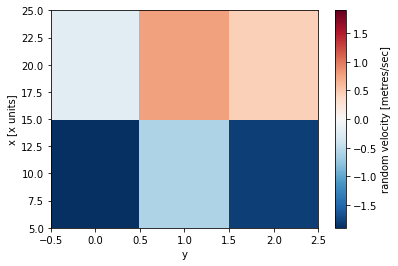

In [81]:
%matplotlib inline
data.plot()

### 与Pandas对象互相转换

Xarray可以方便地转换成Pandas的Series或DataFrame，也可以由Pandas对象转换回Xarray。

In [82]:
# 转换成Pandas的Series
series = data.to_series()
series

x   y
10  0   -1.894778
    1   -0.589974
    2   -1.777589
20  0   -0.217932
    1    0.776169
    2    0.458682
dtype: float64

In [83]:
# Series转换成Xarray
series.to_xarray()

<xarray.DataArray (x: 2, y: 3)>
array([[-1.89477837, -0.58997363, -1.77758946],
       [-0.21793173,  0.77616912,  0.45868184]])
Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 0 1 2

In [88]:
# 转换成Pandas的DataFrame
df = data.to_dataframe(name='colname')
df

colname
x  y          
10 0 -1.894778
   1 -0.589974
   2 -1.777589
20 0 -0.217932
   1  0.776169
   2  0.458682

In [89]:
# DataFrame转换成Xarray
xr.Dataset.from_dataframe(df)

<xarray.Dataset>
Dimensions:  (x: 2, y: 3)
Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 0 1 2
Data variables:
    colname  (x, y) float64 -1.895 -0.59 -1.778 -0.2179 0.7762 0.4587

### Dataset

Dataset是一个类似于字典的DataArray的容器，可以看作是一个具有多为结构的DataFrame。对比NetCDF4库中的Dataset，我们可以发现两者的作用是相似的，都是作为容器用来存储其他的对象。

In [90]:
# 创建一个Dataset，其中包含三个DataArray
ds = xr.Dataset({'foo': data, 'bar': ('x', [1, 2]), 'baz': np.pi})
ds

<xarray.Dataset>
Dimensions:  (x: 2, y: 3)
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Data variables:
    foo      (x, y) float64 -1.895 -0.59 -1.778 -0.2179 0.7762 0.4587
    bar      (x) int64 1 2
    baz      float64 3.142

可以通过字典的方式或者点索引的方式来查看DataArray，但是只有采用字典方式时才可以进行赋值。

In [91]:
# 通过字典方式查看DataArray
print(ds['foo'], '\n')

# 通过点索引的方式查看DataArray
print(ds.foo)

<xarray.DataArray 'foo' (x: 2, y: 3)>
array([[-1.89477837, -0.58997363, -1.77758946],
       [-0.21793173,  0.77616912,  0.45868184]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:         random velocity
    units:             metres/sec
    description:       A random variable created as an example
    ramdom_attribute:  123 

<xarray.DataArray 'foo' (x: 2, y: 3)>
array([[-1.89477837, -0.58997363, -1.77758946],
       [-0.21793173,  0.77616912,  0.45868184]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:         random velocity
    units:             metres/sec
    description:       A random variable created as an example
    ramdom_attribute:  123


同样可以通过坐标标记来索引。

In [92]:
ds.bar.sel(x=10)

<xarray.DataArray 'bar' ()>
array(1)
Coordinates:
    x        int64 10

### 读/写netCDF文件

In [93]:
# 写入到netcdf文件
ds.to_netcdf('xarray_test.nc')

# 读取已存在的netcdf文件
xr.open_dataset('xarray_test.nc')

<xarray.Dataset>
Dimensions:  (x: 2, y: 3)
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Data variables:
    foo      (x, y) float64 ...
    bar      (x) int64 ...
    baz      float64 ...

### 应用

尝试用Xarray来操作一下训练样本中的SODA数据。

In [94]:
# 打开SODA文件
soda = xr.open_dataset('SODA_train.nc')
# 查看文件属性
print(soda.attrs)
# 查看文件中包含的对象
print(soda)

{}
<xarray.Dataset>
Dimensions:  (lat: 24, lon: 72, month: 36, year: 100)
Coordinates:
  * year     (year) int32 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 ... 28 29 30 31 32 33 34 35 36
  * lat      (lat) float64 -55.0 -50.0 -45.0 -40.0 -35.0 ... 45.0 50.0 55.0 60.0
  * lon      (lon) float64 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
Data variables:
    sst      (year, month, lat, lon) float32 ...
    t300     (year, month, lat, lon) float32 ...
    ua       (year, month, lat, lon) float64 ...
    va       (year, month, lat, lon) float64 ...


In [95]:
# 查看维度和坐标
print(soda.dims)
print(soda.coords)

Frozen(SortedKeysDict({'year': 100, 'month': 36, 'lat': 24, 'lon': 72}))
Coordinates:
  * year     (year) int32 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 ... 28 29 30 31 32 33 34 35 36
  * lat      (lat) float64 -55.0 -50.0 -45.0 -40.0 -35.0 ... 45.0 50.0 55.0 60.0
  * lon      (lon) float64 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0


In [100]:
# 读取数据
soda_sst = soda['sst']
print(soda_sst[1, 1, 1, 1], '\n')

soda_t300 = soda['t300']
print(soda_t300[1, 2, 12:24, 36], '\n')

soda_ua = soda['ua']
print(soda_ua[1, 2, 12:24:2, 36:38], '\n')

soda_va = soda['va']
print(soda_va[5:10, 0:12, 12, 36])

<xarray.DataArray 'sst' ()>
array(0.549156, dtype=float32)
Coordinates:
    year     int32 2
    month    int32 2
    lat      float64 -50.0
    lon      float64 5.0 

<xarray.DataArray 't300' (lat: 12)>
array([ 0.350308, -0.271906, -0.394029,  0.534374,  0.378115,  0.371367,
        0.082296,  0.754251,  0.682577,  0.147856,  0.220678,  0.574088],
      dtype=float32)
Coordinates:
    year     int32 2
    month    int32 3
  * lat      (lat) float64 5.0 10.0 15.0 20.0 25.0 ... 40.0 45.0 50.0 55.0 60.0
    lon      float64 180.0 

<xarray.DataArray 'ua' (lat: 6, lon: 2)>
array([[ 1.222841,  1.084187],
       [-0.106073, -0.286916],
       [-0.983318, -0.892802],
       [-1.157512, -1.04381 ],
       [ 1.443658,  1.275039],
       [ 2.179182,  1.776857]])
Coordinates:
    year     int32 2
    month    int32 3
  * lat      (lat) float64 5.0 15.0 25.0 35.0 45.0 55.0
  * lon      (lon) float64 180.0 185.0 

<xarray.DataArray 'va' (year: 5, month: 12)>
array([[ 0.875687,  0.640397,  1.346922

## 作业
基础作业：

1.尝试用NetCDF4和Xarray来操作赛题数据，对数据有基本的了解。

进阶作业：

2.尝试用Xarray对训练数据进行数据探索和数据可视化。